In [1]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [6]:
## Creating Spectograms for Visualizing files
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True) 
    for filename in os.listdir(f'C:/Users/Admin/music_recommender/genres/{g}'):
        songname = f'C:/Users/Admin/music_recommender/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 432x288 with 0 Axes>

In [7]:
## Creating headers for csv file in which data will be stored
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [8]:
## storing data on a csv file
file = open('genre_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'C:/Users/Admin/music_recommender/genres/{g}'):
        songname = f'C:/Users/Admin/music_recommender/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('genre_data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [98]:
## Loading data onto a DataFrame
genre_data = pd.read_csv('genre_data.csv')
print(genre_data.shape)
data = genre_data.drop(['filename','label'], axis=1)
print(data.shape)
genre_data.head()

(1000, 28)
(1000, 26)


,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,...,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,blues.00001.wav,0.340983,0.095918,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,...,5.376803,-2.239120,4.216963,-6.012273,0.936109,-0.716537,0.293876,-0.287431,0.531573,blues
2,blues.00002.wav,0.363603,0.175573,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,...,5.789265,-8.905224,-1.083720,-9.218358,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,blues.00003.wav,0.404779,0.141191,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,...,6.087676,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues
4,blues.00004.wav,0.308590,0.091563,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198799,-35.605450,...,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409332,-11.703781,blues


In [14]:
## Splitting dataset into training and testing data
from sklearn.model_selection import train_test_split
x=data
y=genre_data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=123, test_size=0.2)


In [42]:
## LogisticRegression
from sklearn.preprocessing import StandardScaler    ## To standardise data
from sklearn.pipeline import make_pipeline

logreg1 = make_pipeline(StandardScaler(),LogisticRegression())
logreg1.fit(x_train, y_train)

pred=logreg1.predict(x_test)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg1.score(x_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg1.score(x_test, y_test)))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of Logistic regression classifier on training set: 0.71
Accuracy of Logistic regression classifier on test set: 0.66
[[ 9  1  0  1  0  0  3  0  0  4]
 [ 0 23  1  0  0  0  0  0  0  0]
 [ 3  0 10  2  0  0  0  1  0  1]
 [ 1  0  1 17  3  0  0  0  2  4]
 [ 0  0  1  1  9  0  0  2  1  0]
 [ 1  0  1  0  0  9  0  0  0  1]
 [ 1  0  1  0  1  0 17  0  0  1]
 [ 0  0  0  1  2  0  0 16  0  1]
 [ 0  0  0  3  5  1  0  0 14  0]
 [ 2  0  4  6  0  0  3  0  0  8]]
              precision    recall  f1-score   support

       blues       0.53      0.50      0.51        18
   classical       0.96      0.96      0.96        24
     country       0.53      0.59      0.56        17
       disco       0.55      0.61      0.58        28
      hiphop       0.45      0.64      0.53        14
        jazz       0.90      0.75      0.82        12
       metal       0.74      0.81      0.77        21
         pop       0.84      0.80      0.82        20
      reggae       0.82      0.61      0.70        23
  

In [18]:
## DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

clf = make_pipeline(StandardScaler(), DecisionTreeClassifier())
clf.fit(x_train, y_train)

pred=clf.predict(x_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(x_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(x_test, y_test)))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.44
[[ 7  0  3  2  0  2  3  0  0  1]
 [ 0 18  2  0  0  4  0  0  0  0]
 [ 3  0  5  0  1  2  0  2  3  1]
 [ 1  0  3 10  6  1  2  3  1  1]
 [ 0  0  1  2  6  0  2  1  1  1]
 [ 0  4  1  0  0  6  0  0  1  0]
 [ 3  0  1  0  2  1 14  0  0  0]
 [ 2  0  2  1  3  1  0  8  2  1]
 [ 3  1  1  4  1  2  0  2  8  1]
 [ 0  0  2  4  1  3  1  2  4  6]]
              precision    recall  f1-score   support

       blues       0.37      0.39      0.38        18
   classical       0.78      0.75      0.77        24
     country       0.24      0.29      0.26        17
       disco       0.43      0.36      0.39        28
      hiphop       0.30      0.43      0.35        14
        jazz       0.27      0.50      0.35        12
       metal       0.64      0.67      0.65        21
         pop       0.44      0.40      0.42        20
      reggae       0.40      0.35      0.37        23
        rock  

In [91]:
## Getting accuracy for each depth upto 20
trn={}
tst={}
for i in range(1,20):
    max_depth=int(i)
    clf2 = DecisionTreeClassifier(max_depth=max_depth).fit(x_train, y_train)
    print("#"*10,"max_depth=",max_depth,"#"*10)
    trn[i]=clf2.score(x_train, y_train)
    print('Accuracy on training set : {:.2f}'.format(clf2.score(x_train, y_train)))
    print('Accuracy on test set: {:.2f}'.format(clf2.score(x_test, y_test)))
    tst[i]=clf2.score(x_test, y_test)

########## max_depth= 1 ##########
Accuracy on training set : 0.18
Accuracy on test set: 0.17
########## max_depth= 2 ##########
Accuracy on training set : 0.27
Accuracy on test set: 0.27
########## max_depth= 3 ##########
Accuracy on training set : 0.38
Accuracy on test set: 0.33
########## max_depth= 4 ##########
Accuracy on training set : 0.45
Accuracy on test set: 0.34
########## max_depth= 5 ##########
Accuracy on training set : 0.53
Accuracy on test set: 0.48
########## max_depth= 6 ##########
Accuracy on training set : 0.59
Accuracy on test set: 0.46
########## max_depth= 7 ##########
Accuracy on training set : 0.66
Accuracy on test set: 0.42
########## max_depth= 8 ##########
Accuracy on training set : 0.74
Accuracy on test set: 0.47
########## max_depth= 9 ##########
Accuracy on training set : 0.81
Accuracy on test set: 0.51
########## max_depth= 10 ##########
Accuracy on training set : 0.85
Accuracy on test set: 0.45
########## max_depth= 11 ##########
Accuracy on training se

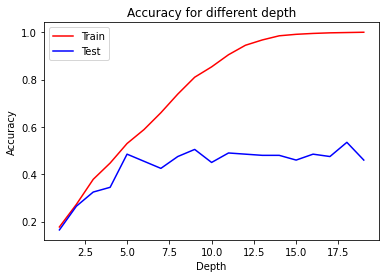

In [92]:
## Plotting accuracy at different depths
plt.plot(list(trn.keys()),list(trn.values()),color="RED",label="Train")
plt.plot(list(tst.keys()),list(tst.values()),color="Blue",label="Test")
plt.title("Accuracy for different depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [95]:
## KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
trn={}
tst={}
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=int(i))
    knn.fit(x_train, y_train)
    print("#"*10,"Neighbours =",i,"#"*10)
    trn[i]=knn.score(x_train, y_train)
    print('Accuracy on training set : {:.2f}'.format(knn.score(x_train, y_train)))
    print('Accuracy on test set: {:.2f}'.format(knn.score(x_test, y_test)))
    tst[i]=knn.score(x_test, y_test)

########## Neighbours = 1 ##########
Accuracy on training set : 1.00
Accuracy on test set: 0.37
########## Neighbours = 2 ##########
Accuracy on training set : 0.65
Accuracy on test set: 0.28
########## Neighbours = 3 ##########
Accuracy on training set : 0.59
Accuracy on test set: 0.32
########## Neighbours = 4 ##########
Accuracy on training set : 0.56
Accuracy on test set: 0.37
########## Neighbours = 5 ##########
Accuracy on training set : 0.53
Accuracy on test set: 0.37
########## Neighbours = 6 ##########
Accuracy on training set : 0.54
Accuracy on test set: 0.40
########## Neighbours = 7 ##########
Accuracy on training set : 0.51
Accuracy on test set: 0.38
########## Neighbours = 8 ##########
Accuracy on training set : 0.50
Accuracy on test set: 0.38
########## Neighbours = 9 ##########
Accuracy on training set : 0.50
Accuracy on test set: 0.38
########## Neighbours = 10 ##########
Accuracy on training set : 0.47
Accuracy on test set: 0.37
########## Neighbours = 11 ##########
A

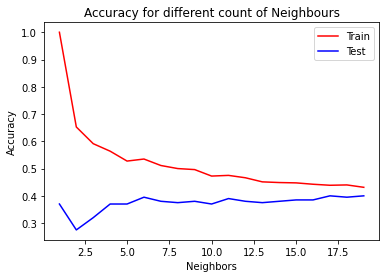

In [99]:
## Plotting accuracy for different levels of k
plt.plot(list(trn.keys()),list(trn.values()),color="RED",label="Train")
plt.plot(list(tst.keys()),list(tst.values()),color="Blue",label="Test")
plt.title("Accuracy for different count of Neighbours")
plt.xlabel("Neighbors")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [71]:
## Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)
pred=lda.predict(x_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(lda.score(x_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(lda.score(x_test, y_test)))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of Decision Tree classifier on training set: 0.67
Accuracy of Decision Tree classifier on test set: 0.68
[[ 9  0  0  1  0  2  3  0  0  3]
 [ 0 22  1  0  0  1  0  0  0  0]
 [ 1  0 11  0  0  1  0  3  0  1]
 [ 0  0  2 14  2  0  1  1  2  6]
 [ 0  0  1  0 11  0  0  1  1  0]
 [ 0  1  1  0  0 10  0  0  0  0]
 [ 1  0  1  0  2  0 16  0  0  1]
 [ 0  1  0  0  2  0  0 16  1  0]
 [ 0  0  0  2  4  0  0  0 15  2]
 [ 0  0  1  7  0  0  3  0  1 11]]
              precision    recall  f1-score   support

       blues       0.82      0.50      0.62        18
   classical       0.92      0.92      0.92        24
     country       0.61      0.65      0.63        17
       disco       0.58      0.50      0.54        28
      hiphop       0.52      0.79      0.63        14
        jazz       0.71      0.83      0.77        12
       metal       0.70      0.76      0.73        21
         pop       0.76      0.80      0.78        20
      reggae       0.75      0.65      0.70        23
        rock  

In [24]:
## Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(x_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(x_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(x_test, y_test)))
pred=gnb.predict(x_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of GNB classifier on training set: 0.42
Accuracy of GNB classifier on test set: 0.45
[[ 4  0  4  1  0  1  7  0  0  1]
 [ 0 22  1  0  0  1  0  0  0  0]
 [ 3  3  4  0  0  2  1  3  1  0]
 [ 0  0  2  1  5  0  9  7  2  2]
 [ 0  0  0  1  3  0  2  7  1  0]
 [ 1  7  0  0  0  4  0  0  0  0]
 [ 2  0  0  0  0  0 17  0  0  2]
 [ 0  0  0  0  1  0  0 17  2  0]
 [ 0  0  2  1  2  0  0  3 14  1]
 [ 1  0  2  1  2  0 11  3  0  3]]
              precision    recall  f1-score   support

       blues       0.36      0.22      0.28        18
   classical       0.69      0.92      0.79        24
     country       0.27      0.24      0.25        17
       disco       0.20      0.04      0.06        28
      hiphop       0.23      0.21      0.22        14
        jazz       0.50      0.33      0.40        12
       metal       0.36      0.81      0.50        21
         pop       0.42      0.85      0.57        20
      reggae       0.70      0.61      0.65        23
        rock       0.33      0.13 

In [25]:
## Support Vector Machines
from sklearn.svm import SVC

svm = SVC()
svm.fit(x_train, y_train)
pred=svm.predict(x_test)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(x_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(x_test, y_test)))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred,zero_division=0))

Accuracy of SVM classifier on training set: 0.28
Accuracy of SVM classifier on test set: 0.28
[[ 3  6  4  0  5  0  0  0  0  0]
 [ 1 22  1  0  0  0  0  0  0  0]
 [ 0  9  2  0  4  0  0  2  0  0]
 [ 0  0  0  0 20  0  0  7  0  1]
 [ 0  0  1  0  9  0  0  4  0  0]
 [ 2  8  0  0  1  0  0  0  1  0]
 [ 0  0  3  0 13  0  4  0  0  1]
 [ 0  0  1  0  5  0  0 13  0  1]
 [ 2  1  7  0 11  0  0  2  0  0]
 [ 2  0  1  0 17  0  0  1  0  2]]
              precision    recall  f1-score   support

       blues       0.30      0.17      0.21        18
   classical       0.48      0.92      0.63        24
     country       0.10      0.12      0.11        17
       disco       0.00      0.00      0.00        28
      hiphop       0.11      0.64      0.18        14
        jazz       0.00      0.00      0.00        12
       metal       1.00      0.19      0.32        21
         pop       0.45      0.65      0.53        20
      reggae       0.00      0.00      0.00        23
        rock       0.40      0.09 

In [81]:
## Creating new csv file and storing data of new input file onto it
file = open('sample_genre_data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for filename in os.listdir(r'C:/Users/Admin/music_recommender/sample'):
        sample_songname = f'C:/Users/Admin/music_recommender/sample/{filename}'
        y, sr = librosa.load(sample_songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        file = open('sample_genre_data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [82]:
## Loading data onto a DataFrame and dropping unneccessary variables before classification
sample_genre_data = pd.read_csv('sample_genre_data.csv')
sample_data = sample_genre_data.drop(['filename','label'], axis=1)